In [1]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from model import MultiScaleCNN
from image_handlers import ImageLoader

#  Multi-Scale CNN model training strategy 

1. Train a model with mall data
2. Further train the model with ShackCam data
3. Adding FC layers and training only the FC layers by setting `mscnn_layer.trainable = False`

# 1. Train a model with mall data

### Load mall data

Total image samples 2000


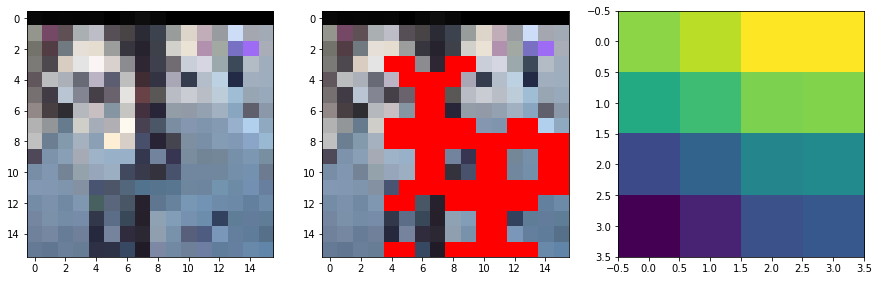

In [2]:
new_shape = 16

mall = ImageLoader(new_shape=new_shape, image_dir='data/mall')
mall.load_train_data()
mall.plot_image(filename='seq_000499.jpg')
print('Total image samples', mall.count)

### Create a model

In [3]:
input_shape = (new_shape, new_shape, 3)

model = MultiScaleCNN(input_shape, 'mall')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   331840      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   200768      conv2d[0][0]                     
_____________________________________

###  Split data to train/test

In [4]:
x_train, x_test, y_train, y_test = train_test_split(mall.org_img, mall.gaussian_img)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (1500, 16, 16, 3) x_test (500, 16, 16, 3)
y_train (1500, 4, 4, 1) y_test (500, 4, 4, 1)


### Assign optimizer and compile a model

Instructions for updating:
Use tf.cast instead.
Train on 450 samples, validate on 50 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
450/450 [==============================] - 116s 259ms/sample - loss: 1251.8469 - val_loss: 2.8263
Epoch 2/2
450/450 [==============================] - 106s 235ms/sample - loss: 2.5152 - val_loss: 2.2281


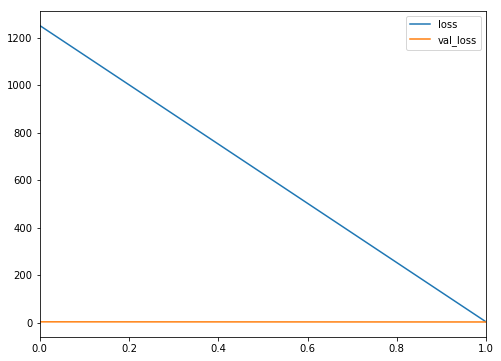

In [5]:
# model.train(x_train, y_train, epochs=10, batch_size=16)
model.train(x_test, y_test, epochs=2, batch_size=16)

In [6]:
model.evaluate(x_test, y_test)

500/500 [==============================] - 22s 44ms/sample - loss: 1.9891
Train score: 2.5151845688290067
Test score: 1.9890652980804444


# 2. Further train the same model with ShackCam data

### Load shackcam data

Total image samples 3878


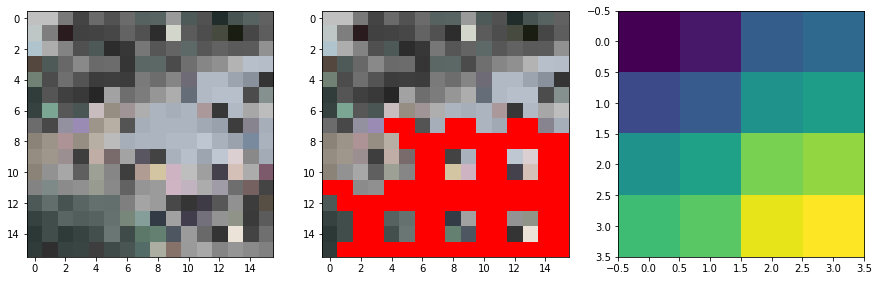

In [7]:
shackcam = ImageLoader(new_shape=new_shape, image_dir='data/shackcam')
shackcam.load_train_data()
shackcam.plot_image(i=500)
print('Total image samples', shackcam.count)

### Split data to train/test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(shackcam.org_img, shackcam.gaussian_img)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (2908, 16, 16, 3) x_test (970, 16, 16, 3)
y_train (2908, 4, 4, 1) y_test (970, 4, 4, 1)


### Load pre-trained weights

In [12]:
model = MultiScaleCNN(input_shape, 'shackcam')
model.load_weights('results/mall_mscnn_weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16, 16, 3)    0                                            
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 16, 16, 64)   15616       input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 16, 16, 64)   331840      conv2d_92[0][0]                  
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 16, 16, 64)   200768      conv2d_92[0][0]                  
__________________________________________________________________________________________________
conv2d_95 

### Assign optimizer and compile a model

Train on 873 samples, validate on 97 samples
Epoch 1/2
873/873 [==============================] - 227s 260ms/sample - loss: 3.9665 - val_loss: 2.9796
Epoch 2/2
873/873 [==============================] - 211s 242ms/sample - loss: 3.0715 - val_loss: 3.0519


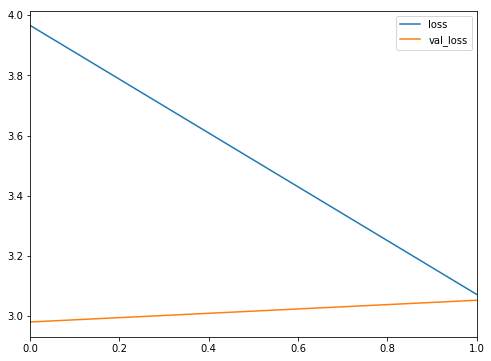

In [13]:
# model.train(x_train, y_train, epochs=10, batch_size=16)
model.train(x_test, y_test, epochs=2, batch_size=16)

### Save results and inspect loss

In [14]:
model.evaluate(x_test, y_test)

970/970 [==============================] - 44s 45ms/sample - loss: 3.0067
Train score: 3.071531440657302
Test score: 3.006689474754727


# Adding FC layers and training only the FC layers

### Read line counts, align order as shackcam annotations, remove files without counts

In [15]:
counts = pd.read_csv('data/shackcam/line_counts.csv', names=['file', 'line_count'], header=None)
counts = counts[counts.file.isin(shackcam.files)]
gaussian_img = np.array([shackcam.data[f]['gaussian_img'] for f in counts.file])

In [16]:
x_train, x_test, y_train, y_test = train_test_split(gaussian_img, counts.line_count.values)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (2907, 4, 4, 1) x_test (970, 4, 4, 1)
y_train (2907,) y_test (970,)


In [32]:
input_shape = (new_shape//4, new_shape//4, 1)

model = MultiScaleCNN(input_shape, 'shackcam_fc', fc=True)

ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_30/MaxPool' (op: 'MaxPool') with input shapes: [?,1,1,1].

In [19]:
model.train(x_test, y_test, epochs=2, batch_size=16)

ValueError: Error when checking input: expected model_5_input to have shape (16, 16, 3) but got array with shape (4, 4, 1)